In [ ]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:41999")
client

In [2]:
import numpy as np
import xarray as xr
import os.path as op
import matplotlib.colors as clr
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
ddir = '/bettik/uchidat/qg-ML/'

In [14]:
U     = .1
T     = 5e5    # seconds
L     = U*T
tau0  = .0001
dt    = 5e-2
Rd    = 5e4   # Rossby radius (50km)
Re4   = 4e3
# f0 = 8e-5
beta  = .5
N     = 1024   # Number of horizontal grids
L0    = 80
H     = 5e3
dx    = L0/N  # Non-dimensionalized horizontal resolution ((L0*Rd)/N)/Rd
diny  = 360
Rom   = .025
Ekb   = .002*2
ntime = int(62.2*5)+1

percent = 20
nmemb = 100

ncoars = 4
DX = dx * ncoars

In [4]:
def eigen(A):
    eigenValues, eigenVectors = np.linalg.eigh(A)
    idx = np.argsort(np.abs(eigenValues))
    eigenValues = eigenValues[idx]
    eigenVectors = eigenVectors[:,idx]
    return (eigenValues, eigenVectors)

/tmp/ipykernel_39516/2613721643.py:14: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  eigvals, eigvecs = xr.apply_ufunc(eigen, S,


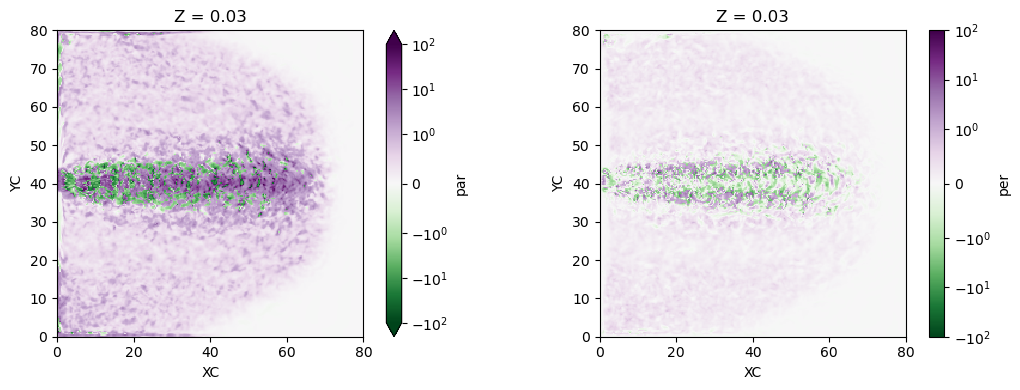

152


/tmp/ipykernel_39516/2613721643.py:14: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  eigvals, eigvecs = xr.apply_ufunc(eigen, S,


153


/tmp/ipykernel_39516/2613721643.py:14: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  eigvals, eigvecs = xr.apply_ufunc(eigen, S,


154


/tmp/ipykernel_39516/2613721643.py:14: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  eigvals, eigvecs = xr.apply_ufunc(eigen, S,


155


In [11]:
ncoars = 4

tts = 152
for tt in range(tts,156):
    K = xr.open_zarr(op.join(ddir,'Diff-tensor/nC%02d/%010d.zarr'
                             % (ncoars,tt))
                    ).K
    Kt = K.transpose('Z','YC','XC','row','col')
    
    S = .5*xr.DataArray(K.data + Kt.data, dims=K.dims,
                        coords=K.coords
                       ).chunk({'Z':1,'col':-1,'row':-1})
    
    eigvals, eigvecs = xr.apply_ufunc(eigen, S, 
                                      input_core_dims=[['row','col']],
                                      vectorize=True,
                                      dask="parallelized",
                                      output_core_dims=[['ii'], ['k','ii']],
                                      output_sizes={'ii':2, 'k':2}
                                     )
    
    eval_par = xr.DataArray(eigvals[...,1].data, dims=['Z','YC','XC'],
                            coords={'Z':K.Z.data,'YC':K.YC.data,'XC':K.XC.data},
                            name='par'
                           )
    eval_per = xr.DataArray(eigvals[...,0].data, dims=['Z','YC','XC'],
                            coords={'Z':K.Z.data,'YC':K.YC.data,'XC':K.XC.data},
                            name='per'
                           )
    
    if tt == tts:
        fig, (ax1, ax2) = plt.subplots(figsize=(11,4), nrows=1, ncols=2)
        fig.set_tight_layout(True)
        eval_par.isel(Z=0).plot(ax=ax1, cmap='PRGn_r', 
                     norm=clr.SymLogNorm(vmax=1e2, vmin=-1e2, linthresh=1e0))
        eval_per.isel(Z=0).plot(ax=ax2, cmap='PRGn_r', 
                     norm=clr.SymLogNorm(vmax=1e2, vmin=-1e2, linthresh=1e0))
        ax1.set_aspect('equal')
        ax2.set_aspect('equal')
        plt.show()

    dsave = eval_par.to_dataset(name='par')
    dsave['per'] = eval_per
    dsave.par.encoding = {}
    dsave.per.encoding = {}
    dsave.chunk({'Z':1,'YC':128,'XC':128}).to_zarr(op.join(ddir,
                                                   'Diff-tensor/nC%02d/S-eigen/%010d.zarr'
                                                           % (ncoars,tt)), 
                                                   mode='w')
    print(tt)

In [12]:
for tt in range(312):
    if tt == 0:
        dsl = xr.open_zarr(op.join(ddir, 'Diff-tensor/nC%02d/S-eigen/%010d.zarr'
                                   % (ncoars,tt))
                          )
    else:
        dsl = xr.concat([dsl,xr.open_zarr(op.join(ddir, 
                                                  'Diff-tensor/nC%02d/S-eigen/%010d.zarr'
                                                  % (ncoars,tt)))
                        ], 'time')
dsl

/tmp/ipykernel_39516/2979959370.py:3: RuntimeWarning: Failed to open Zarr store with consolidated metadata, but successfully read with non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolidated=False, to avoid trying to read consolidate metadata, or
3. Explicitly setting consolidated=True, to raise an error in this case instead of falling back to try reading non-consolidated metadata.
  dsl = xr.open_zarr(op.join(ddir, 'Diff-tensor/nC%02d/S-eigen/%010d.zarr'
/tmp/ipykernel_39516/2979959370.py:7: RuntimeWarning: Failed to open Zarr store with consolidated metadata, but successfully read with non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolid

<xarray.Dataset>
Dimensions:  (XC: 256, YC: 256, Z: 3, time: 312)
Coordinates:
  * XC       (XC) float64 0.1562 0.4688 0.7812 1.094 ... 78.91 79.22 79.53 79.84
  * YC       (YC) float64 0.1562 0.4688 0.7812 1.094 ... 78.91 79.22 79.53 79.84
  * Z        (Z) float64 0.03 0.13 0.6
Dimensions without coordinates: time
Data variables:
    par      (time, Z, YC, XC) float64 dask.array<chunksize=(1, 1, 128, 128), meta=np.ndarray>
    per      (time, Z, YC, XC) float64 dask.array<chunksize=(1, 1, 128, 128), meta=np.ndarray>

In [25]:
time = xr.DataArray(np.arange(len(dsl.time)), dims='time',
                    coords={'time':dsl.time.data}
                   )
Zp1 = dsl.Z.rolling(Z=2, center=True).mean().dropna('Z')
Frm = xr.DataArray(np.array([0.00409959,0.01319355]), dims='Zp1', 
                   coords={'Zp1':Zp1.data}
                  )
aFrN = xr.DataArray(np.array([0.1,0.]), dims='Zp1', 
                    coords={'Zp1':Zp1.data}
                   )
fFr_r = 62.2
Fr = np.sqrt(1. + np.sin(2*np.pi*fFr_r**-1*time)*aFrN)**-1 * Frm
gp = Fr**-2 * dsl.Z.diff('Z').data

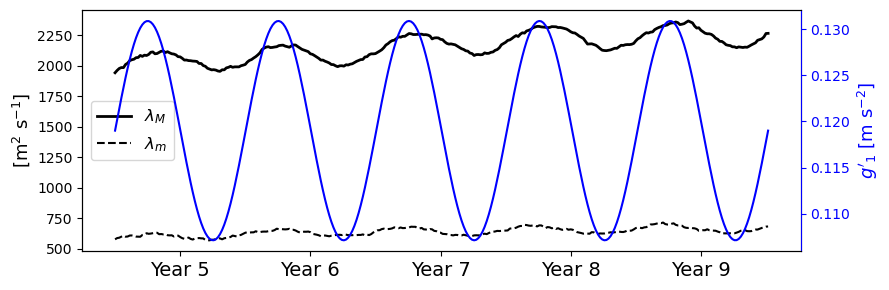

In [31]:
fig, ax = plt.subplots(figsize=(9,3))
fig.set_tight_layout(True)
ax2 = ax.twinx()

ax.plot(time, np.nanmedian(dsl.par.isel(Z=0)*U*L, (-1,-2)), 'k', 
        label=r'$\lambda_M$', lw=2
       )
ax.plot(time, np.nanmedian(dsl.per.isel(Z=0)*U*L, (-2,-1)), 'k--', 
        label=r'$\lambda_m$'
       )

ax2.plot(time, gp.isel(Zp1=0)* U**2/(dsl.Z.diff('Z')[0].data*H), 'b')

ax2.spines['right'].set_color('blue')
ax2.yaxis.label.set_color('blue')
ax2.tick_params(axis='y', colors='blue')
ax.set_xticks(np.arange(31,len(dsl.time),62))
ax.set_xticklabels(["Year 5", "Year 6", "Year 7", "Year 8", "Year 9"], 
                   fontsize=14)
ax.set_ylabel(r"[m$^2$ s$^{-1}$]", fontsize=13)
ax2.set_ylabel(r"$g'_1$ [m s$^{-2}$]", color='b', fontsize=13)

ax.legend(loc='center left', fontsize=12)
plt.savefig(op.join(ddir, 'Figs/TimeSeries_Seigen.pdf'))